In [1]:
import re
import pandas as pd
import numpy as np
import tensorflow as tf
from IPython.display import clear_output
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, hamming_loss, accuracy_score, roc_auc_score
from google.colab import drive
from os.path import join
import nltk
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import KFold
import seaborn as sns
from collections import Counter
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy

nltk.download("stopwords", quiet=True)

True

In [3]:
drive.mount("/content/drive/", force_remount=False)
DATA_PATH = "/content/drive/My Drive/Colab Notebooks/ML4MDE_Project/"


file = join(DATA_PATH,'dataset.csv')
df = pd.read_csv(file, header=0)

Mounted at /content/drive/


<hr />
<h2>Data Preprocessing</h2>

In [4]:
contraction_mapping = {
    "ain't": "is not",
    "aren't": "are not",
    "can't": "cannot",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'll": "he will",
    "he's": "he is",
    "how'd": "how did",
    "how'd'y": "how do you",
    "how'll": "how will",
    "how's": "how is",
    "I'd": "I would",
    "I'd've": "I would have",
    "I'll": "I will",
    "I'll've": "I will have",
    "I'm": "I am",
    "I've": "I have",
    "i'd": "i would",
    "i'd've": "i would have",
    "i'll": "i will",
    "i'll've": "i will have",
    "i'm": "i am",
    "i've": "i have",
    "isn't": "is not",
    "it'd": "it would",
    "it'd've": "it would have",
    "it'll": "it will",
    "it'll've": "it will have",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "mightn't've": "might not have",
    "must've": "must have",
    "mustn't": "must not",
    "mustn't've": "must not have",
    "needn't": "need not",
    "needn't've": "need not have",
    "o'clock": "of the clock",
    "oughtn't": "ought not",
    "oughtn't've": "ought not have",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "shan't've": "shall not have",
    "she'd": "she would",
    "she'd've": "she would have",
    "she'll": "she will",
    "she'll've": "she will have",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "shouldn't've": "should not have",
    "so've": "so have",
    "so's": "so as",
    "this's": "this is",
    "that'd": "that would",
    "that'd've": "that would have",
    "that's": "that is",
    "there'd": "there would",
    "there'd've": "there would have",
    "there's": "there is",
    "here's": "here is",
    "they'd": "they would",
    "they'd've": "they would have",
    "they'll": "they will",
    "they'll've": "they will have",
    "they're": "they are",
    "they've": "they have",
    "to've": "to have",
    "wasn't": "was not",
    "we'd": "we would",
    "we'd've": "we would have",
    "we'll": "we will",
    "we'll've": "we will have",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what will",
    "what'll've": "what will have",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "when's": "when is",
    "when've": "when have",
    "where'd": "where did",
    "where's": "where is",
    "where've": "where have",
    "who'll": "who will",
    "who'll've": "who will have",
    "who's": "who is",
    "who've": "who have",
    "why's": "why is",
    "why've": "why have",
    "will've": "will have",
    "won't": "will not",
    "won't've": "will not have",
    "would've": "would have",
    "wouldn't": "would not",
    "wouldn't've": "would not have",
    "y'all": "you all",
    "y'all'd": "you all would",
    "y'all'd've": "you all would have",
    "y'all're": "you all are",
    "y'all've": "you all have",
    "you'd": "you would",
    "you'd've": "you would have",
    "you'll": "you will",
    "you'll've": "you will have",
    "you're": "you are",
    "you've": "you have"
}

stop_words = set(nltk.corpus.stopwords.words('english'))

def clean_text(text: str):
    to_clean = text.lower()
    to_clean = to_clean.replace('"', '')
    to_clean = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in to_clean.split(" ")])
    to_clean = re.sub("[^a-zA-Z]", " ", to_clean)
    words = [word for word in to_clean.split() if word not in stop_words and len(word) > 1]
    return " ".join(words).strip()

In [5]:
df["comment_text"] = df["comment_text"].apply(clean_text)
X = df["comment_text"].values
y = df[df.columns[2:]].values

<ipython-input-11-a501608477e8>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=label_counts.values, y=label_counts.index, palette='viridis')


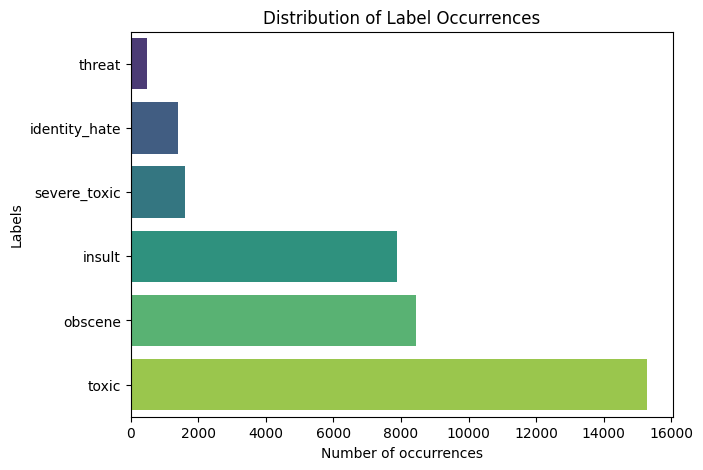

The exact values for each class are:


threat             478
identity_hate     1405
severe_toxic      1595
insult            7877
obscene           8449
toxic            15294
dtype: int64

In [11]:
# Displaying the class distribution of the 'label' column
column_labels = df.columns.tolist()[2:]
label_counts = df[column_labels].sum().sort_values()

# Creating a black background for the graphic
plt.figure(figsize=(7, 5))

# Creating a horizontal bar graph using Seaborn
ax = sns.barplot(x=label_counts.values, y=label_counts.index, palette='viridis')

# Adding labels and title to the graph
plt.xlabel('Number of occurrences')
plt.ylabel('Labels')
plt.title('Distribution of Label Occurrences')

# Show graph
plt.show()

print(f"The exact values for each class are:")
df[column_labels].sum().sort_values()

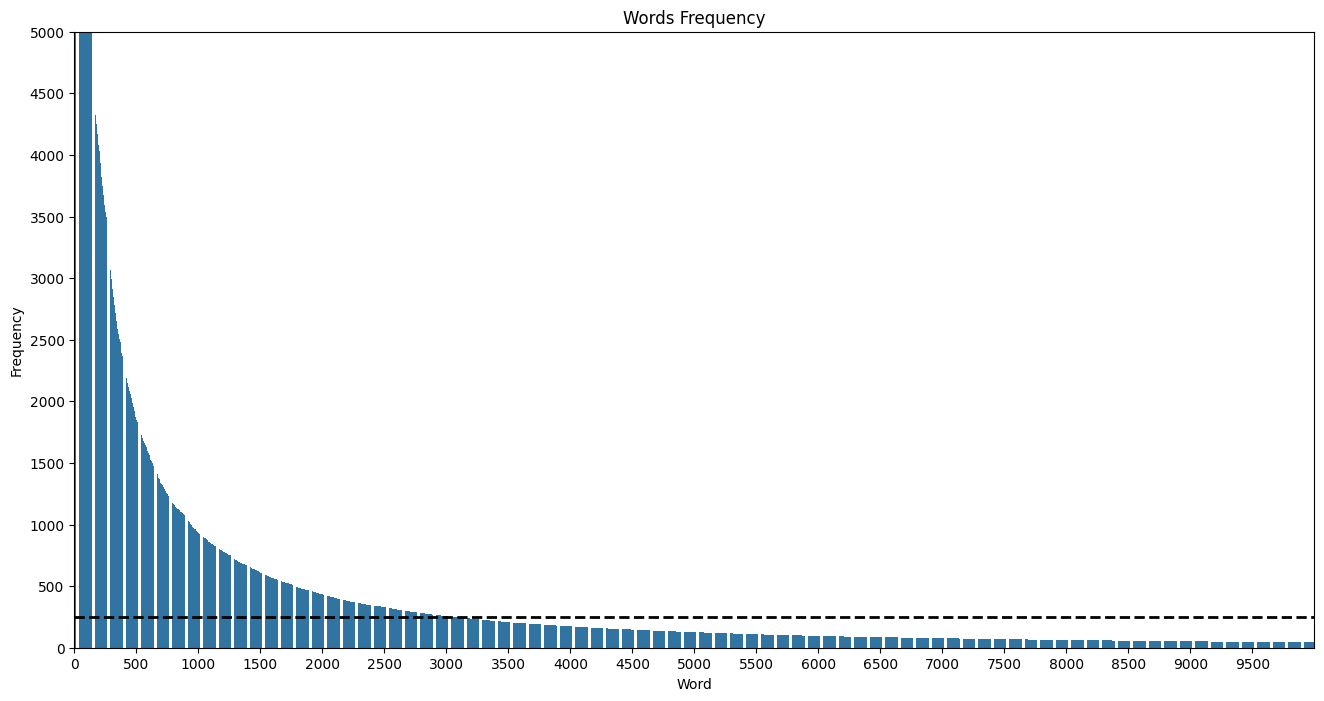

In [12]:
words = [word for comment in X for word in comment.split()]
word_counts = Counter(words)
N = 10000 # Number of words to plot.
interval = 500
top_words = word_counts.most_common(N)
words, frequencies = zip(*top_words)
plt.figure(figsize=(16, 8))
sns.barplot(x=range(len(words)), y=frequencies)
plt.title(f"Words Frequency")
plt.xlabel("Word")
plt.ylabel("Frequency")
x_labels = [f"{i * interval}" for i in range(N // interval)] # Build x-axis labels.
plt.xticks(range(0, N, interval), x_labels) # Set x-axis labels.
plt.ylim(0, 5000)  # Set y-axis limits.
plt.yticks(range(0, 5000 + 1, interval))
plt.axhline(y=250, color="black", linestyle='--', linewidth=2) # Horizontal line.
plt.show()

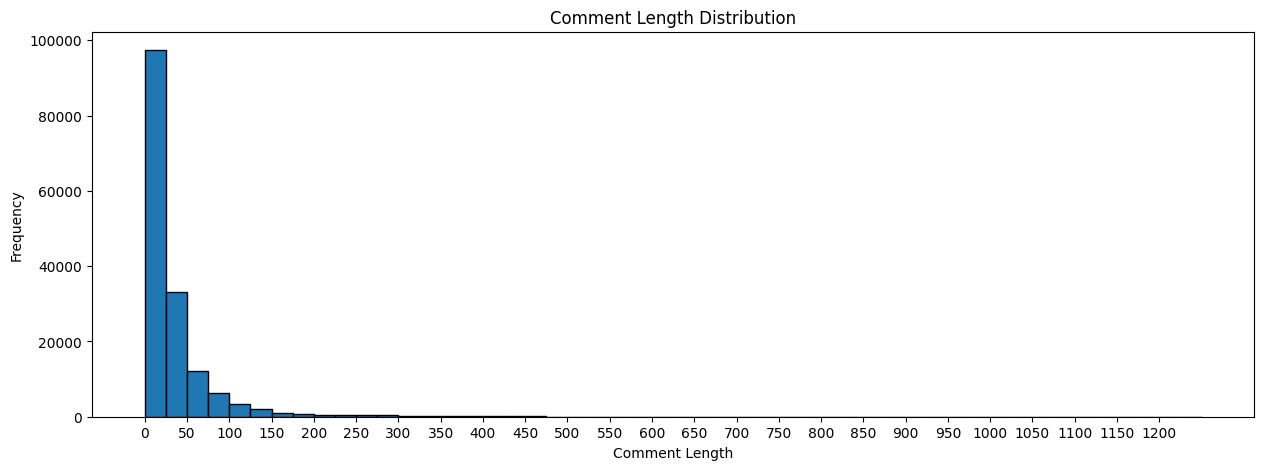

In [13]:
sentence_lengths = [len(comment.split()) for comment in X]
plt.figure(figsize=(15, 5))
plt.hist(sentence_lengths, bins=50, edgecolor="black")
plt.title("Comment Length Distribution")
plt.xlabel("Comment Length")
plt.ylabel("Frequency")
plt.xticks(range(0, 1200 + 1, 50)) # Set x-axis labels.
plt.show()

In [14]:
# Text Vectorization
MAX_FEATURES = 3000
MAX_SEQUENCE = 100
vectorizer = TextVectorization(max_tokens=MAX_FEATURES, output_sequence_length=MAX_SEQUENCE, output_mode='int')
vectorizer.adapt(X)
X = np.array(vectorizer(X))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

In [15]:
# Build the Neural Network.
NUM_EPOCHS = 3
BATCH_SIZE = 32

model = Sequential()

model.add(Embedding(MAX_FEATURES + 1, 32))

model.add(Bidirectional(LSTM(32, activation="tanh")))

model.add(Dense(64, activation="relu"))
model.add(Dense(64, activation="relu"))

model.add(Dense(6, activation="sigmoid"))

model.compile(loss="BinaryCrossentropy", metrics=["accuracy"], optimizer="Adam")

In [16]:
# K-FOLD CROSS VALIDATION
NUM_FOLDS = 2
KF = KFold(n_splits=NUM_FOLDS, shuffle=True, random_state=10)

print("K Cross Fold Validation START")
index = 1
for train_index, val_index in KF.split(X_train):
  print(f"Fold {index}")
  X_fold_train, X_fold_val = X_train[train_index], X_train[val_index]
  y_fold_train, y_fold_val = y_train[train_index], y_train[val_index]

  model.fit(X_fold_train, y_fold_train, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_fold_val, y_fold_val))

  scores = model.evaluate(X_fold_val, y_fold_val)
  print(f"Fold {index} => Loss: {scores[0]:.2f} and Accuracy: {scores[1]*100:.2f}%")
  index += 1
print("K Cross Fold Validation END")

K Cross Fold Validation START
Fold 1
Epoch 1/3
1995/1995 [==============================] - 87s 41ms/step - loss: 0.0819 - accuracy: 0.9755 - val_loss: 0.0589 - val_accuracy: 0.9942
Epoch 2/3
1995/1995 [==============================] - 37s 19ms/step - loss: 0.0572 - accuracy: 0.9939 - val_loss: 0.0584 - val_accuracy: 0.9942
Epoch 3/3
1995/1995 [==============================] - 11s 5ms/step - loss: 0.0576 - accuracy: 0.9942
Fold 1 => Loss: 0.06 and Accuracy: 99.42%
Fold 2
Epoch 1/3
1995/1995 [==============================] - 34s 17ms/step - loss: 0.0569 - accuracy: 0.9830 - val_loss: 0.0527 - val_accuracy: 0.9940
Epoch 2/3
1995/1995 [==============================] - 32s 16ms/step - loss: 0.0526 - accuracy: 0.9880 - val_loss: 0.0526 - val_accuracy: 0.9940
Epoch 3/3
1995/1995 [==============================] - 11s 5ms/step - loss: 0.0538 - accuracy: 0.9940
Fold 2 => Loss: 0.05 and Accuracy: 99.40%
K Cross Fold Validation END


In [17]:
# Train the model with the entire dataset.
model.fit(X_train, y_train, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE)
model.summary()

Epoch 1/3
3990/3990 [==============================] - 50s 13ms/step - loss: 0.0505 - accuracy: 0.9880
Epoch 2/3
3990/3990 [==============================] - 46s 11ms/step - loss: 0.0478 - accuracy: 0.9911
Epoch 3/3
3990/3990 [==============================] - 46s 12ms/step - loss: 0.0455 - accuracy: 0.9837
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          96032     
                                                                 
 bidirectional (Bidirection  (None, 64)                16640     
 al)                                                             
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
           

In [18]:
# Calculate metrics (Precision, Recall, Accuracy)
precision = Precision()
recall = Recall()
accuracy = CategoricalAccuracy()

y_predicted = model.predict(X_test)
y_predicted = (y_predicted > 0.5).astype(int)

# Calculate metrics.
precision.update_state(y_test, y_predicted)
precision_value = precision.result().numpy()
recall.update_state(y_test, y_predicted)
recall_value = recall.result().numpy()
accuracy.update_state(y_test, y_predicted)
accuracy_value = accuracy.result().numpy()
hamming_loss_value = hamming_loss(y_test, y_predicted)
f1_value = (2 * precision_value * recall_value) / (precision_value + recall_value)

print(f"Precision: {precision_value:.2f}")
print(f"Recall:{recall_value:.2f}")
print(f"Accuracy:{accuracy_value:.2f}")
print(f"Hamming Loss: {hamming_loss_value:.2f}")
print(f"F-1 Score: {f1_value:.2f}")

998/998 [==============================] - 5s 4ms/step
Precision: 0.81
Recall:0.63
Accuracy:0.99
Hamming Loss: 0.02
F-1 Score: 0.71


In [19]:
# Evaluating the model.
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)

labels = ["toxic", "sever toxic", "obscene", "threat", "insult", "identity hate"]

# Precision, Recall, F1-Score foreach label.
precision = precision_score(y_test, y_pred, average=None)
recall = recall_score(y_test, y_pred, average=None)
f1 = f1_score(y_test, y_pred, average=None)

for i in range(len(precision)):
    print(f"Label {labels[i]}: Precision = {precision[i]:.2f}, Recall = {recall[i]:.2f}, F1-Score = {f1[i]:.2f}")

998/998 [==============================] - 5s 5ms/step
Label toxic: Precision = 0.89, Recall = 0.63, F1-Score = 0.74
Label sever toxic: Precision = 0.56, Recall = 0.43, F1-Score = 0.48
Label obscene: Precision = 0.81, Recall = 0.77, F1-Score = 0.79
Label threat: Precision = 0.00, Recall = 0.00, F1-Score = 0.00
Label insult: Precision = 0.74, Recall = 0.64, F1-Score = 0.68
Label identity hate: Precision = 0.62, Recall = 0.15, F1-Score = 0.24


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


ROC AUC: 0.71


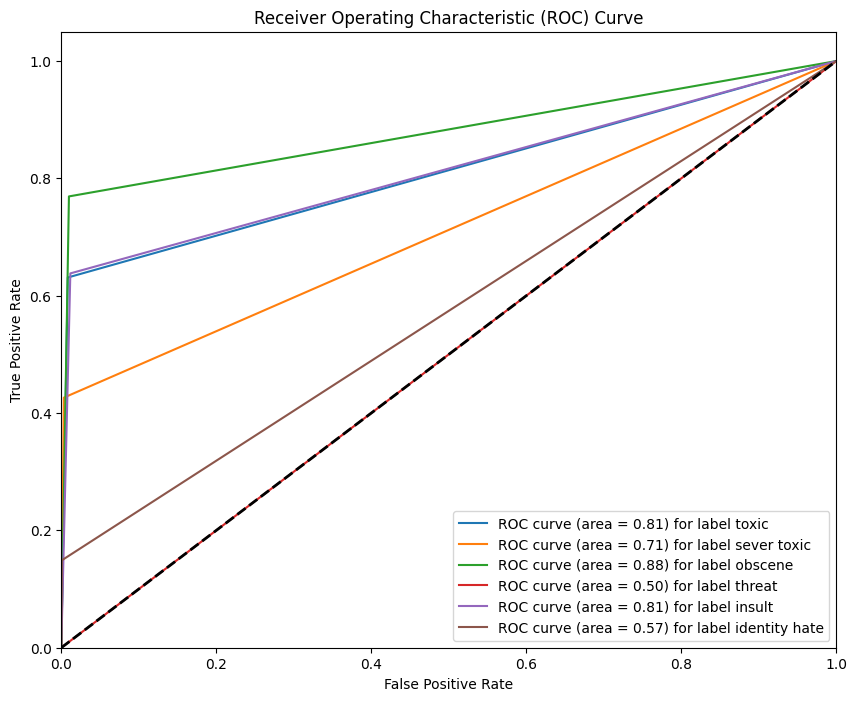

In [20]:
# Area under the ROC curve (ROC AUC) foreach label.
roc_auc = roc_auc_score(y_test, y_pred)
print(f'ROC AUC: {roc_auc:.2f}')

# Binarize the labels.
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3, 4, 5])
n_classes = y_test_binarized.shape[1]

# Calculate the ROC curve and the area under the curve (AUC) foreach label.
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Draw the ROC curve foreach label.
plt.figure(figsize=(10, 8))

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve (area = {roc_auc[i]:.2f}) for label {labels[i]}')

plt.plot([0, 1], [0, 1], 'k--', lw=2) # Horizontal line.
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [21]:
# Save the models.
model.save('toxicity.h5')
model.save('toxicity.keras')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [22]:
# Play with the model.
test = vectorizer("You are ugly!")
predict = model.predict(np.expand_dims(test, 0))
(predict > 0.5).astype(int)

1/1 [==============================] - 0s 66ms/step


array([[1, 0, 0, 0, 0, 0]])

In [ ]:
# Support Vector Machine (SVM) Classification
from sklearn.svm import SVC
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import make_scorer, average_precision_score
from sklearn.model_selection import cross_val_score, train_test_split

# Function for SVM classification
def svm_classification(X, y):
    mlb = MultiLabelBinarizer()
    y_bin = mlb.fit_transform(y)
    svm_classifier = SVC(kernel='linear', probability=True)
    average_precision_scorer = make_scorer(average_precision_score, greater_is_better=True, needs_proba=True)
    cross_val_results = cross_val_score(svm_classifier, X, y_bin, cv=5, scoring=average_precision_scorer)
    return cross_val_results.mean(), cross_val_results.std()

X = np.array(vectorizer(df["comment_text"].values))
y = df[df.columns[2:]].values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

# Apply SVM classification to the training data
svm_mean, svm_std = svm_classification(X_train, y_train)
print("SVM Cross-Validation Average Precision: {:.4f} (+/- {:.4f})".format(svm_mean, svm_std))
